---

# Customer Churn: InClass Kaggle Competition - Python 
#### Author Shruti Bajpai

This notebook gives an example on the implementation of machine learning pipeline for the InClass Kaggle Competition.

Last update on: 19/04/2021
Editor/Owner: Shruti Bajpai

---

The machine learning pipeline includes:

1. Data processing 
- [x] Error correction
- [x] Value transformation
- [x] Value representation
- [x] Variable selection

2. Modeling 
- [x] Machine Learning Models

3. Model Implementation  
- [x] Obtaining Output to Test Kaggle

In [1]:
# Version
exp_version = 'v5'  # Experiment version
data_prep = 'std'  # full = data transformation, representation, std = standard, only dummy encode
var_set = 'all'  # all = all vars, fs = top fisher score, pca = first PCs
fname = '_' + data_prep + '_' + var_set + '_' + exp_version  # Name of output file
print(fname)

_std_all_v5


In [2]:
# Flag variables to run the data processing steps
# Value transformation step
enable_trans_cat_dt = False  # Remapping cat variables - Decision tree–based remapping
enable_trans_num_dt = False  # Discretizing num variables - Decision tree–based discretization
enable_trans_num_ef = False  # Discretizing num variables - Equal frequency discretization
enable_trans_num_ew = False  # Discretizing num variables - Equal width discretization
# Value representation step
enable_repr_dummy = True  # Represent cat variables - Dummy coding
enable_repr_icd = False  # Represent cat variables - Incidence (of target variable) replacement
enable_repr_woe = False  # Represent cat variables - Weight-of-Evidence (WoE) conversion
drop_cat_vars = True  # Drop cat variables after value representation step
# Other data processing
enable_normalize = True  # Normalize the data to the same range [0, 1]

## Initiation

In [3]:
# Data exploration
import matplotlib.pyplot as plt

# Data processing
import pickle
import numpy as np
import pandas as pd
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OrdinalEncoder, OneHotEncoder, KBinsDiscretizer
from sklearn.preprocessing import MinMaxScaler
from sklearn.feature_selection import mutual_info_classif, VarianceThreshold
from sklearn.feature_selection import SelectFromModel
from sklearn.decomposition import PCA

# Modeling
from sklearn.linear_model import LogisticRegression
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier, AdaBoostClassifier
from sklearn.svm import LinearSVC
from sklearn.neural_network import MLPClassifier
import xgboost as xgb

# Experimental setup
from sklearn.model_selection import KFold, StratifiedKFold, cross_validate, GridSearchCV
from imblearn.over_sampling import SMOTE, RandomOverSampler
from imblearn.pipeline import Pipeline
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import learning_curve

## 1. Data summary

#### (a) Read and print out some data

In [4]:
# Read train, test
train = pd.read_csv('orange_churn_train.csv', low_memory=False)
test = pd.read_csv('orange_churn_test.csv', low_memory=False)

In [5]:
# Print out to check the data
print(train.dtypes.value_counts())
train.head()

float64    191
object      38
int64        3
dtype: int64


,cust_id,Var1,Var2,Var3,Var4,Var5,Var6,Var7,Var8,Var9,...,Var222,Var223,Var224,Var225,Var226,Var227,Var228,Var229,Var230,churn
0,3,NaN,NaN,NaN,NaN,NaN,1351.0,7.0,NaN,NaN,...,catzS2D,LM8l689qOp,NaN,ELof,7P5s,ZI9m,NoEd,mj86,NaN,0
1,4,NaN,NaN,NaN,NaN,NaN,644.0,0.0,NaN,NaN,...,76DJixu,LM8l689qOp,NaN,NaN,7P5s,RAYp,F2FyR07IdsN7I,NaN,NaN,0
2,7,NaN,NaN,NaN,NaN,NaN,2583.0,0.0,NaN,NaN,...,I5dzv5f,LM8l689qOp,NaN,NaN,FSa2,RAYp,F2FyR07IdsN7I,NaN,NaN,1
3,8,NaN,NaN,NaN,NaN,NaN,1463.0,7.0,NaN,NaN,...,xwyAw04,LM8l689qOp,NaN,kG3k,fKCe,RAYp,F2FyR07IdsN7I,mj86,NaN,0
4,9,NaN,NaN,NaN,NaN,NaN,77.0,0.0,NaN,NaN,...,76DJixu,NaN,NaN,NaN,7P5s,RAYp,F2FyR07IdsN7I,NaN,NaN,0


#### (b) Create a list of column names to manage variables

In [6]:
# List of numerical and catergorical variables
id_var = ["cust_id"]  # ID
num_vars = train.columns[1:191].tolist()  # First 190 vars
cat_vars = train.columns[191:231].tolist()  # Last 40 vars
# Target get variable
target_var = ["churn"]

#### (c) Check the target variable class distribution

In [7]:
# By number
print(train[target_var].value_counts())
# By percentage
print(train[target_var].value_counts(normalize=True))

churn
0        9264
1         736
dtype: int64
churn
0        0.9264
1        0.0736
dtype: float64


## 2. Processing data

### 2.1. Error, data correction

#### (a) Check and correct data error - Constant variables

Constant variables on train do not contain information and may cause data processing or model training error.

In [8]:
# Count number of unique values of each variable
vars_nunique = train[num_vars + cat_vars].apply(pd.Series.nunique, dropna=False, axis=0)
cont_vars = vars_nunique.index[vars_nunique < 2].tolist()
print("Drop constant variable:", cont_vars)
# Correct variable list
num_vars = [v for v in num_vars if v not in cont_vars]
cat_vars = [v for v in cat_vars if v not in cont_vars]
# Update train, test
train = train[id_var+num_vars+cat_vars+target_var]
test = test[id_var+num_vars+cat_vars]

Drop constant variable: ['Var8', 'Var15', 'Var20', 'Var31', 'Var32', 'Var39', 'Var42', 'Var48', 'Var52', 'Var55', 'Var79', 'Var141', 'Var167', 'Var169', 'Var175', 'Var185', 'Var209', 'Var230']


#### (b) Check and correct data error - Missing values

<u>Note:</u>
- Always create indicators (dummy variable) to track the missing values imputation.
- Since we already filtered out the constant NA vars, the imputor will not drop any vars.

In [9]:
# Check missing value
print('Train - # NA of num vars:', train[num_vars].isna().sum().sum())
print('Train - # NA of cat vars:', train[cat_vars].isna().sum().sum())
print('Test - # NA of num vars:', test[num_vars].isna().sum().sum())
print('Test - # NA of cat vars:', test[cat_vars].isna().sum().sum())

Train - # NA of num vars: 1345535
Train - # NA of cat vars: 79067
Test - # NA of num vars: 1345234
Test - # NA of cat vars: 79296


In [10]:
# List dummary variables to track missing values imputation
na_vars = []

In [11]:
# Numerical variables
# Build the missing value imputor using the mean
imp = SimpleImputer(missing_values=np.nan, strategy='mean', add_indicator=True)
imp.fit(train[num_vars])
# Reconstruct the list of vars + indicators
na_vars = na_vars + [num_vars[v] + "_na" for v in imp.indicator_.features_]
impute_vars = num_vars + na_vars
# Apply on train, test
train[impute_vars] = pd.DataFrame(imp.transform(train[num_vars]), columns=impute_vars)
test[impute_vars] = pd.DataFrame(imp.transform(test[num_vars]), columns=impute_vars)

In [12]:
# Categorical variables
# Impute missing value using a new category "Missing"
# Note: If the categorical vars are imputed by most_frequent, the indicators should be added
train[cat_vars] = train[cat_vars].fillna('Missing')
test[cat_vars] = test[cat_vars].fillna('Missing')

#### (c) Check and correct data error - Outliers in numerical variables

Here, we only check but not impute the outliers.

<u>Note:</u>
- Before correcting outliers, make sure to understand the nature of the error.
- Do not need to correct outliers for missing values indicators.

In [13]:
# Check the outliers on train, test
for v in num_vars:
    # Calculate the boundaries on train [mean-3*sd, mean+3*sd]
    mu = np.mean(train[v])
    sd = np.std(train[v])
    lower = mu - 3*sd
    upper = mu + 3*sd
    # Check outliers using the boundaries
    train_out = (train[v] < lower) | (train[v] > upper)
    test_out = (test[v] < lower) | (test[v] > upper)
    if np.sum(train_out) + np.sum(test_out) > 0:
        print(v, "has # outliers on train, test :",
              np.sum(train_out), "[", np.round(100*np.mean(train_out), 2), "% ]",
              np.sum(test_out), "[", np.round(100*np.mean(test_out), 2), "% ]")

Var1 has # outliers on train, test : 21 [ 0.21 % ] 21 [ 0.21 % ]
Var3 has # outliers on train, test : 12 [ 0.12 % ] 3 [ 0.03 % ]
Var4 has # outliers on train, test : 2 [ 0.02 % ] 3 [ 0.03 % ]
Var5 has # outliers on train, test : 27 [ 0.27 % ] 29 [ 0.29 % ]
Var6 has # outliers on train, test : 85 [ 0.85 % ] 85 [ 0.85 % ]
Var7 has # outliers on train, test : 214 [ 2.14 % ] 190 [ 1.9 % ]
Var9 has # outliers on train, test : 66 [ 0.66 % ] 76 [ 0.76 % ]
Var10 has # outliers on train, test : 37 [ 0.37 % ] 32 [ 0.32 % ]
Var11 has # outliers on train, test : 18 [ 0.18 % ] 14 [ 0.14 % ]
Var12 has # outliers on train, test : 75 [ 0.75 % ] 81 [ 0.81 % ]
Var13 has # outliers on train, test : 85 [ 0.85 % ] 72 [ 0.72 % ]
Var14 has # outliers on train, test : 14 [ 0.14 % ] 11 [ 0.11 % ]
Var16 has # outliers on train, test : 200 [ 2.0 % ] 174 [ 1.74 % ]
Var17 has # outliers on train, test : 32 [ 0.32 % ] 37 [ 0.37 % ]
Var18 has # outliers on train, test : 12 [ 0.12 % ] 18 [ 0.18 % ]
Var19 has # outlie

Var179 has # outliers on train, test : 8 [ 0.08 % ] 10 [ 0.1 % ]
Var180 has # outliers on train, test : 109 [ 1.09 % ] 122 [ 1.22 % ]
Var181 has # outliers on train, test : 173 [ 1.73 % ] 153 [ 1.53 % ]
Var182 has # outliers on train, test : 215 [ 2.15 % ] 238 [ 2.38 % ]
Var183 has # outliers on train, test : 31 [ 0.31 % ] 18 [ 0.18 % ]
Var184 has # outliers on train, test : 35 [ 0.35 % ] 27 [ 0.27 % ]
Var186 has # outliers on train, test : 125 [ 1.25 % ] 141 [ 1.41 % ]
Var187 has # outliers on train, test : 56 [ 0.56 % ] 58 [ 0.58 % ]
Var188 has # outliers on train, test : 189 [ 1.89 % ] 160 [ 1.6 % ]
Var189 has # outliers on train, test : 124 [ 1.24 % ] 137 [ 1.37 % ]
Var190 has # outliers on train, test : 40 [ 0.4 % ] 52 [ 0.52 % ]


#### (d) Encode categorical variables

In Python, most of the machine learning libraries will not handle non-numerical values of categorical varibales (e.g. RF). Therefore, we should encoded the categories using integer values.

<u>Note:</u>
- Here, the encoder is fitted on both train and test. Therefore, in a few special cases, there are unique categories that appear only on train, or test.

In [14]:
# Encode categorical variables as integer values
# Note: All the NA values were imputed previously
enc = OrdinalEncoder()
enc.fit(pd.concat([train[cat_vars], test[cat_vars]], axis=0))
# Apply on train, test
train[cat_vars] = enc.transform(train[cat_vars])
test[cat_vars] = enc.transform(test[cat_vars])

#### (e) Finalize the processed data

Current lists of variables:
- id_var : customer ID
- num_vars : numerical variables
- cat_vars : categorical variables
- na_vars : indicators for tracking missing values, bool [False, True]
- target_var : target variable, churn [0, 1]

<u>Note:</u> If there are any variables exist in only train or test, drop them from all the data.

In [15]:
# Convert bool variable to int
train[na_vars] = train[na_vars].astype(np.int8)
test[na_vars] = test[na_vars].astype(np.int8)

In [16]:
# Print out the final variables
print("# id_var [", len(id_var), "] :", id_var)
print("# num_vars [", len(num_vars), "] :", num_vars[:5], "...")
print("# cat_vars [", len(cat_vars), "] :", cat_vars[:5], "...")
print("# na_vars [", len(na_vars), "] :", na_vars[:5], "...")
print("# target_var [", len(target_var), "] :", target_var)

# id_var [ 1 ] : ['cust_id']
# num_vars [ 174 ] : ['Var1', 'Var2', 'Var3', 'Var4', 'Var5'] ...
# cat_vars [ 38 ] : ['Var191', 'Var192', 'Var193', 'Var194', 'Var195'] ...
# na_vars [ 171 ] : ['Var1_na', 'Var2_na', 'Var3_na', 'Var4_na', 'Var5_na'] ...
# target_var [ 1 ] : ['churn']


In [17]:
# Sort the data according to the variables list
train = train[id_var + num_vars + cat_vars + na_vars + target_var]
test = test[id_var + num_vars + cat_vars + na_vars]
print(train.shape)
print(test.shape)

(10000, 385)
(10000, 384)


### 2.2. Feature engineering

Since every variables are anonymized, we cannot create new variables based the meaning of current variables.

In other case, we can use the following hints:
- Quickly check the potentially important variables.
- Focus on the most important variables to create new variables.
- Create a cross variable framework (e.g. customer activities, date-time, events, etc.) for searching the new variables.

#### (a) Quickly detect most (potentially) important varriables - Correlation test for numerical variables

In [18]:
# Pearson's correlation for numerical variables
corr = train[num_vars + target_var].corr(method='pearson')
corr = corr['churn'][:-1].dropna()
print("Top 5 vars [+] correlated with target var :"); print(corr.sort_values(ascending=False)[:5])
print("Top 5 vars [-] correlated with target var :"); print(corr.sort_values(ascending=True)[:5])

Top 5 vars [+] correlated with target var :
Var113    0.054660
Var131    0.033685
Var126    0.030609
Var173    0.029983
Var81     0.028262
Name: churn, dtype: float64
Top 5 vars [-] correlated with target var :
Var189   -0.087654
Var73    -0.073407
Var7     -0.059302
Var65    -0.047361
Var13    -0.039086
Name: churn, dtype: float64


#### (b) Quickly detect most (potentially) important varriables - Mutual information

<u>Reference:</u>
- Mutual information. Link: https://en.wikipedia.org/wiki/Mutual_information
- sklearn.feature_selection.mutual_info_classif. Link: https://scikit-learn.org/stable/modules/generated/sklearn.feature_selection.mutual_info_classif.html

In [19]:
# Check mutual information for all variables
# Note: The calculation involves a random process, therefore, the result may change if there is no
# variable with significant information.
mutual_info = mutual_info_classif(train[cat_vars], train[target_var].values.squeeze())
mutual_info = pd.Series(mutual_info, index=cat_vars)
print("Top 10 vars :"); print(mutual_info.sort_values(ascending=False)[:10])

Top 10 vars :
Var193    0.009399
Var210    0.008983
Var217    0.007949
Var205    0.006955
Var218    0.006935
Var221    0.006823
Var212    0.006762
Var202    0.005104
Var192    0.005007
Var208    0.004731
dtype: float64


####  (a) Variable selection: Fisher Score

In [26]:
# Create several lists to handle variables
id_var = ['cust_id']
target_var = ['churn']
predictors = [v for v in train.columns if v not in id_var + target_var]

In [27]:
def FisherScore(bt, target_var, predictors):
    """
    This function calculate the Fisher score of a variable.

    Ref:
    ---
    Verbeke, W., Dejaeger, K., Martens, D., Hur, J., & Baesens, B. (2012). New insights
    into churn prediction in the telecommunication sector: A profit driven data mining
    approach. European Journal of Operational Research, 218(1), 211-229.
    """
    
    # Get the unique values of dependent variable
    target_var_val = bt[target_var].unique()
    # Calculate FisherScore for each predictor
    predictor_FisherScore = []
    for v in predictors:
        fs = np.abs(np.mean(bt.loc[bt[target_var]==target_var_val[0], v]) - np.mean(bt.loc[bt[target_var]==target_var_val[1], v])) / \
             np.sqrt(np.var(bt.loc[bt[target_var]==target_var_val[0], v]) + np.var(bt.loc[bt[target_var]==target_var_val[1], v]))
        predictor_FisherScore.append(fs)
    return predictor_FisherScore

In [28]:
# Calculate Fisher Score for all variable
fs = FisherScore(train, target_var[0], predictors)
fs_df = pd.DataFrame({"predictor":predictors, "fisherscore":fs})
fs_df = fs_df.sort_values('fisherscore', ascending=False)
fs_df.head()

<ipython-input-27-0c2aaa030081>:17: RuntimeWarning: invalid value encountered in double_scalars
  fs = np.abs(np.mean(bt.loc[bt[target_var]==target_var_val[0], v]) - np.mean(bt.loc[bt[target_var]==target_var_val[1], v])) / \
<ipython-input-27-0c2aaa030081>:17: RuntimeWarning: invalid value encountered in double_scalars
  fs = np.abs(np.mean(bt.loc[bt[target_var]==target_var_val[0], v]) - np.mean(bt.loc[bt[target_var]==target_var_val[1], v])) / \
<ipython-input-27-0c2aaa030081>:17: RuntimeWarning: invalid value encountered in double_scalars
  fs = np.abs(np.mean(bt.loc[bt[target_var]==target_var_val[0], v]) - np.mean(bt.loc[bt[target_var]==target_var_val[1], v])) / \


,predictor,fisherscore
323,Var126_na,0.271197
172,Var189,0.230800
62,Var73,0.217568
200,Var218,0.196487
6,Var7,0.164765


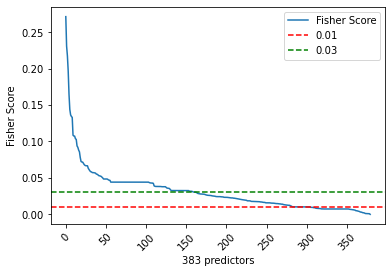

In [29]:
# Visualize the Fisher Score
plt.plot(fs_df['fisherscore'].values.squeeze())
plt.axhline(y=0.01, linestyle='dashed', color='red')
plt.axhline(y=0.03, linestyle='dashed', color='green')
plt.xticks(rotation=45)
plt.xlabel(str(fs_df.shape[0]) + ' predictors')
plt.ylabel('Fisher Score')
plt.legend(['Fisher Score', '0.01', '0.03'])
plt.show()

In [30]:
# Select the top variables based on Fisher Score
# top_fs_vars = fs_df[fs_df['fisherscore'] >= 0.03]['predictor'].values
top_fs_vars = fs_df['predictor'].values[:50]
print("Selected # vars :", len(top_fs_vars))
top_fs_vars

Selected # vars : 50


array(['Var126_na', 'Var189', 'Var73', 'Var218', 'Var7', 'Var113',
       'Var207', 'Var65', 'Var13', 'Var193', 'Var144', 'Var229', 'Var210',
       'Var220', 'Var126', 'Var205', 'Var140', 'Var228', 'Var81',
       'Var125', 'Var74', 'Var195', 'Var72', 'Var6', 'Var134',
       'Var118_na', 'Var92_na', 'Var197', 'Var28', 'Var200', 'Var194',
       'Var201', 'Var147', 'Var221', 'Var119', 'Var109', 'Var112',
       'Var51', 'Var173', 'Var77', 'Var203', 'Var211', 'Var160', 'Var37',
       'Var132', 'Var24', 'Var222', 'Var81_na', 'Var144_na', 'Var6_na'],
      dtype=object)

#### (b) Dimensional Reduction: PCA

In [32]:
# Build PCA and check the explained variance
# Note: If the num vars were scaled (but the dummy were not) PVE is no longer correct
pca = PCA(n_components=100)
pca.fit(train[predictors])
print("PVE =", pca.explained_variance_ratio_.sum())
# Transform train, test
train_pca = pca.transform(train[predictors])
test_pca = pca.transform(test[predictors])

PVE = 0.9999999999945487


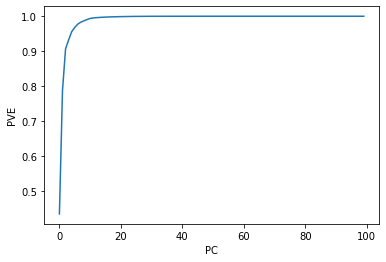

In [33]:
# Visualize the PVE of PCA
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('PC')
plt.ylabel('PVE')
plt.show()

## Basetable

In [42]:
train_pca_df = pd.DataFrame(train_pca)
test_pca_df = pd.DataFrame(test_pca)

In [44]:
#Basetable
train_pca_df

,0,1,2,3,4,5,6,7,8,9,...,90,91,92,93,94,95,96,97,98,99
0,4.120921e+06,1382.926563,2.618250e+05,6.033320e+05,-5.149695e+05,-6637.074611,-7.528463e+04,385215.727461,55236.920600,-144.246584,...,-4.197877,-0.809334,5.247311,-1.769750,-6.093992,1.623660,0.170005,6.351277,0.614337,4.847624
1,1.208672e+06,1126.443975,-1.615208e+06,-8.799284e+05,-6.591156e+05,-37307.011877,-4.190200e+05,-190482.880666,143341.238830,-1816.791105,...,2.923935,1.858305,20.208964,2.960141,4.557753,-1.202465,-0.806956,-18.726068,-1.345178,-11.643057
2,9.419038e+05,537.525459,-1.332966e+06,-5.601405e+05,1.531879e+06,-13119.961209,-1.348529e+05,-704117.095401,153799.187888,-787.823424,...,3.403000,0.708272,4.871062,-2.005455,-8.675416,2.512780,0.090229,-0.006291,0.677992,4.256737
3,-2.333822e+06,-1074.781947,-1.369667e+06,3.449439e+05,1.832196e+06,13228.576349,1.522140e+05,195109.117998,-367104.593475,670.095719,...,5.922022,0.571973,4.785329,-1.092374,-5.517926,1.056064,0.066631,4.535946,0.941230,4.744873
4,3.174109e+06,798.582080,4.588345e+05,4.712176e+06,1.362118e+06,-8922.338713,-6.740531e+04,573973.508708,44521.147589,146.516082,...,-2.822054,0.429935,6.802518,-0.438395,-0.844239,0.293897,-0.293586,2.224526,-0.218235,0.173227
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,-7.046638e+06,-1853.091286,4.177761e+05,-3.247449e+05,-1.555218e+05,-17973.521973,-2.043957e+05,-29937.059424,105298.418646,-877.460732,...,-4.392665,-0.315855,-0.905852,2.618980,13.854976,-3.151031,-0.487023,-3.305908,-0.154423,1.513349
9996,-5.897648e+06,-1106.707416,-1.568983e+05,-2.670548e+05,2.384702e+05,-39808.698040,-4.428090e+05,-147602.218538,64090.314445,-1909.415017,...,-3.828710,0.155877,6.892568,0.093047,-0.810010,0.492026,0.312018,19.120845,-0.916041,-8.871794
9997,-3.191363e+06,-1731.729132,-1.795086e+05,7.118814e+05,3.769904e+05,36113.725863,4.069311e+05,-47091.126869,-144291.677140,1671.885244,...,-4.081403,0.682411,8.017443,-1.677489,-5.731592,1.734728,0.166540,3.875549,-0.178679,-2.516850
9998,-7.606501e+04,2796.343902,1.128226e+04,-5.508521e+04,-1.937103e+04,-152240.402074,-1.689305e+06,-54123.953771,-5642.505321,211486.051989,...,3.211039,-157.548728,1.509314,0.564259,2.022103,-0.396009,-0.571295,-2.258200,0.150928,4.205040


In [45]:
basetable = train_pca_df.to_csv(r'C:\Users\bajpa\Desktop\IESEG\Stastical and Machine Learning Approaches\Individual Project\Final Individual Project Folder\shruti_basetable_kaggle.csv')

## 3. Modeling

<u>Reference:</u>  

- Lessmann, S., Baesens, B., Seow, H. V., & Thomas, L. C. (2015). Benchmarking state-of-the-art classification algorithms for credit scoring: An update of research. European Journal of Operational Research, 247(1), 124-136.File 

In [73]:
import sys
import pandas               as pd
import numpy                as np
import seaborn              as sns
import matplotlib.pyplot    as plt
from pandas                 import DataFrame
from pandas                 import read_csv
from pandas                 import Series
from numpy                  import array
from numpy                  import random
from matplotlib             import pyplot
import warnings
from pandas               import get_dummies
from numpy                import where
from numpy                import nan
from scipy.stats.mstats   import winsorize

warnings.filterwarnings("ignore")

from scipy.stats.mstats import winsorize
from scipy.stats          import pearsonr
import warnings
from sklearn import linear_model
from sklearn.linear_model   import LogisticRegression
from sklearn.tree           import DecisionTreeClassifier
from sklearn.ensemble       import RandomForestClassifier
from sklearn.ensemble       import GradientBoostingClassifier
from sklearn.svm            import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors      import KNeighborsClassifier
from sklearn.metrics        import auc
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve
from sklearn.metrics        import accuracy_score
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics        import auc
from sklearn.metrics        import roc_auc_score
from sklearn.metrics        import confusion_matrix

In [ ]:
train.head(2)

In [137]:
train_pca.shape

(10000, 100)

In [86]:
scaler = MinMaxScaler()
x_train = scaler.fit_transform(x_train)
x_test = scaler.transform(x_test)

In [161]:
x_train,x_test,y_train,y_test=train_test_split(train_pca,train['churn'],test_size = 0.2, random_state = 123)

In [139]:
# Instanciating the Models

tree         = DecisionTreeClassifier()
logistic     = LogisticRegression(solver = "lbfgs", max_iter = 500)
randomForest = RandomForestClassifier(n_estimators = 100)
boostedTree  = GradientBoostingClassifier()
svm          = SVC(gamma = "scale", probability = True)
neuralNet    = MLPClassifier()
neighbors    = KNeighborsClassifier() 

In [141]:
#Import Gaussian Naive Bayes model
from sklearn.naive_bayes import GaussianNB

#Create a Gaussian Classifier
gnb = GaussianNB()

#Train the model using the training sets
gnb.fit(x_train, y_train)

#Predict the response for test dataset
y_pred = gnb.predict(x_test)

## 4. Make prediction

Use the best model to make prediction on test set. Submit the result to Kaggle.

### Nearest Neighbors

In [ ]:
# 0.53507 nearest neighbors score for kaggle 8 submission

In [215]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaler.fit(x_train)

x_train = scaler.transform(x_train)
x_test = scaler.transform(x_test)

In [216]:
from sklearn.neighbors import KNeighborsClassifier
classifier = KNeighborsClassifier(n_neighbors=5)
classifier.fit(x_train, y_train)

KNeighborsClassifier()

In [217]:
prediction_neighbors = classifier.predict(test_pca)

In [218]:
predictionproba_neighbors = neighbors.predict_proba(test_pca)

In [219]:
result_neighbors = pd.DataFrame(predictionproba_neighbors)
print(result_neighbors[1])

0       0.4
1       0.0
2       0.0
3       0.0
4       0.2
       ... 
9995    0.2
9996    0.0
9997    0.2
9998    0.0
9999    0.2
Name: 1, Length: 10000, dtype: float64


In [220]:
test['prediction'] = result_neighbors[1]

In [221]:
export_result_neighbors = test[['cust_id','prediction']]
export_result_neighbors.to_csv(r"C:\Users\bajpa\Desktop\IESEG\Stastical and Machine Learning Approaches\Individual Project\kaggle8.csv")

### Decision Tree

In [ ]:
# 0.52327 score for kaggle 7

In [206]:
tree.fit(x_train,y_train)

DecisionTreeClassifier()

In [207]:
prediction_tree = tree.predict(test_pca)

In [209]:
predictionproba_tree = tree.predict_proba(test_pca)

In [210]:
result_tree = pd.DataFrame(predictionproba_tree)
print(result_tree[1])

0       0.0
1       0.0
2       0.0
3       0.0
4       1.0
       ... 
9995    1.0
9996    0.0
9997    0.0
9998    0.0
9999    0.0
Name: 1, Length: 10000, dtype: float64


In [211]:
test['prediction'] = result_tree[1]

In [212]:
export_result_result_tree = test[['cust_id','prediction']]
export_result_result_tree.to_csv(r"C:\Users\bajpa\Desktop\IESEG\Stastical and Machine Learning Approaches\Individual Project\kaggle7.csv")

### Neural Network

In [199]:
neuralNet.fit(x_train,y_train)

MLPClassifier()

In [201]:
prediction_neuralNet = neuralNet.predict(test_pca)

In [202]:
predictionproba_neuralNet = neuralNet.predict_proba(test_pca)

In [203]:
result_neuralNet = pd.DataFrame(predictionproba_neuralNet)
print(result_neuralNet[1])

0       2.402785e-02
1       4.480473e-04
2       2.435504e-03
3       7.013080e-02
4       3.298309e-03
            ...     
9995    4.675560e-02
9996    4.551238e-10
9997    4.210335e-01
9998    7.892970e-05
9999    6.673683e-04
Name: 1, Length: 10000, dtype: float64


In [204]:
test['prediction'] = result_neuralNet[1]

In [205]:
export_result_neuralNet = test[['cust_id','prediction']]
export_result_neuralNet.to_csv(r"C:\Users\bajpa\Desktop\IESEG\Stastical and Machine Learning Approaches\Individual Project\kaggle6.csv")

### Random Forest

In [ ]:
#random forest 0.58371 kaggle 5

In [193]:
randomForest.fit(x_train,y_train)

RandomForestClassifier()

In [194]:
prediction_randomForest = randomForest.predict(test_pca)

In [195]:
predictionproba_randomForest = randomForest.predict_proba(test_pca)

In [196]:
result_randomForest = pd.DataFrame(predictionproba_randomForest)
print(result_randomForest[1])

0       0.05
1       0.04
2       0.01
3       0.16
4       0.13
        ... 
9995    0.07
9996    0.10
9997    0.07
9998    0.01
9999    0.07
Name: 1, Length: 10000, dtype: float64


In [197]:
test['prediction'] = result_randomForest[1]

In [198]:
export_result_randomForest = test[['cust_id','prediction']]
export_result_randomForest.to_csv(r"C:\Users\bajpa\Desktop\IESEG\Stastical and Machine Learning Approaches\Individual Project\kaggle5.csv")

### Logistic Regression

In [ ]:
#0.65556 Logistic regression submission kaggle 4

In [187]:
logreg = LogisticRegression()
logreg.fit(x_train, y_train)

LogisticRegression()

In [188]:
prediction_logistic = logreg.predict(test_pca)

In [189]:
predictionproba_logistic = logreg.predict_proba(test_pca)

In [190]:
result_logistic = pd.DataFrame(predictionproba_logistic)
print(result_logistic[1])

0       0.131396
1       0.071057
2       0.073368
3       0.110457
4       0.125005
          ...   
9995    0.128260
9996    0.003006
9997    0.125729
9998    0.043923
9999    0.079804
Name: 1, Length: 10000, dtype: float64


In [191]:
test['prediction'] = result_logistic[1]

In [192]:
export_result_logisticreg = test[['cust_id','prediction']]
export_result_logisticreg.to_csv(r"C:\Users\bajpa\Desktop\IESEG\Stastical and Machine Learning Approaches\Individual Project\kaggle4.csv")

### Boosted Tree

In [ ]:
#0.61277 for total score kaggle 3

In [174]:
boostedTree.fit(x_train,y_train)

GradientBoostingClassifier()

In [175]:
prediction_boostedTree=boostedTree.predict_proba(test_pca)

In [176]:
print(prediction_boostedTree)

[[0.8977669  0.1022331 ]
 [0.95543891 0.04456109]
 [0.94846415 0.05153585]
 ...
 [0.91165384 0.08834616]
 [0.94223132 0.05776868]
 [0.95694303 0.04305697]]


In [177]:
result_boostedTree = pd.DataFrame(prediction_boostedTree)
print(result_boostedTree[1])

0       0.102233
1       0.044561
2       0.051536
3       0.114491
4       0.072607
          ...   
9995    0.091968
9996    0.028753
9997    0.088346
9998    0.057769
9999    0.043057
Name: 1, Length: 10000, dtype: float64


In [184]:
test['prediction'] = result_boostedTree[1]

In [185]:
export_result_boostedTree = test[['cust_id','prediction']]
export_result_boostedTree.to_csv(r"C:\Users\bajpa\Desktop\IESEG\Stastical and Machine Learning Approaches\Individual Project\kaggle3.csv")

### SVM

In [ ]:
#worst score... 0.49976 kaggle 2

In [ ]:
from sklearn.svm import SVC
svclassifier = SVC(kernel='linear

In [166]:
linear')
svclassifier.probability = True
svclassifier.fit(x_train, y_train)

SVC(kernel='linear', probability=True)

In [168]:
prediction_svm=svclassifier.predict_proba(test_pca)

In [169]:
print(prediction_svm)

[[0.90659015 0.09340985]
 [0.90197247 0.09802753]
 [0.93590126 0.06409874]
 ...
 [0.91292222 0.08707778]
 [0.88682783 0.11317217]
 [0.92290393 0.07709607]]


In [171]:
result_svm = pd.DataFrame(prediction_svm)
print(result_svm[1])

0       0.093410
1       0.098028
2       0.064099
3       0.063769
4       0.084125
          ...   
9995    0.068830
9996    0.081103
9997    0.087078
9998    0.113172
9999    0.077096
Name: 1, Length: 10000, dtype: float64


In [172]:
test['prediction'] = result_svm[1]

In [173]:
export_result_svm = test[['cust_id','prediction']]
export_result_svm.to_csv(r"C:\Users\bajpa\Desktop\IESEG\Stastical and Machine Learning Approaches\Individual Project\kaggle2.csv")

### Naive Bayes

In [ ]:
# 0.58385 is the score kaggle 1

In [144]:
prediction=gnb.predict(test_pca)

In [145]:
predictionproba = gnb.predict_proba(test_pca)

In [146]:
print(predictionproba)

[[0.72057035 0.27942965]
 [0.96567739 0.03432261]
 [0.14775198 0.85224802]
 ...
 [0.9780142  0.0219858 ]
 [0.96505571 0.03494429]
 [0.93943088 0.06056912]]


In [149]:
result = pd.DataFrame(predictionproba)
print(result[1])

0       0.279430
1       0.034323
2       0.852248
3       0.381420
4       0.016880
          ...   
9995    0.366915
9996    0.000221
9997    0.021986
9998    0.034944
9999    0.060569
Name: 1, Length: 10000, dtype: float64


In [151]:
test['prediction'] = result[1]

In [154]:
export_result = test[['cust_id','prediction']]
export_result.to_csv(r"C:\Users\bajpa\Desktop\IESEG\Stastical and Machine Learning Approaches\Individual Project\kaggle1.csv")

In [140]:
models = {"tree"         :tree,
          "logistic"     :logistic,
          "randomForest" :randomForest,
          "boostedTree"  :boostedTree,
          "svm"          :svm,
          "neuralNet"    :neuralNet,
          "neighbors"    :neighbors
         } 

In [89]:
for model in models:
    models[model].fit(x_train,y_train)
    print(f"{model} has been trained successfully")

tree has been trained successfully
logistic has been trained successfully
randomForest has been trained successfully
boostedTree has been trained successfully
svm has been trained successfully
neuralNet has been trained successfully
neighbors has been trained successfully


In [91]:
performances_train = {}

for model in models:
    predictions   = models[model].predict(x_train)
    probabilities = DataFrame(models[model].predict_proba(x_train))[1]
    accuracy      = accuracy_score(y_train,predictions)
    auc           = roc_auc_score(array(y_train),array(probabilities))
    
    performances_train[model] = {"Accuracy":accuracy,"AUC":auc,"Probabilities":probabilities}

In [93]:
# performances on the training set
DataFrame(performances_train)

,tree,logistic,randomForest,boostedTree,svm,neuralNet,neighbors
Accuracy,1.0,0.958833,0.999833,0.929667,0.9265,1.0,0.929333
AUC,1.0,0.996891,1.0,0.957889,1.0,1.0,0.911736
Probabilities,0 0.0 1 0.0 2 0.0 3 0....,0 0.023321 1 0.085306 2 0.06...,0 0.05 1 0.04 2 0.03 3 ...,0 0.031389 1 0.094468 2 0.07...,0 0.060821 1 0.067713 2 0.06...,0 3.277046e-04 1 4.984098e-04 2 ...,0 0.0 1 0.0 2 0.0 3 0....


In [99]:
performances_test = {}

for model in models:
    predictions_test   = models[model].predict(x_test)
    probabilities_test = DataFrame(models[model].predict_proba(x_test))[1]
    accuracy_test      = accuracy_score(y_test,predictions_test)
    auc_test           = roc_auc_score(array(y_test),array(probabilities_test))
    
    performances_test[model] = {"Probabilities":probabilities_test,"AUC":auc}

In [100]:
# performances on the test set
DataFrame(performances_test)

,tree,logistic,randomForest,boostedTree,svm,neuralNet,neighbors
Probabilities,0 0.0 1 0.0 2 0.0 3 0....,0 0.012720 1 0.011290 2 0.22...,0 0.01 1 0.01 2 0.12 3 ...,0 0.055930 1 0.053589 2 0.04...,0 0.037654 1 0.041775 2 0.17...,0 2.467119e-04 1 1.587239e-05 2 ...,0 0.0 1 0.0 2 0.0 3 0....
AUC,0.911736,0.911736,0.911736,0.911736,0.911736,0.911736,0.911736


In [108]:
y_test

2656    0
445     0
9505    0
332     0
4168    0
       ..
8018    0
6463    0
2883    0
7895    0
620     0
Name: churn, Length: 2000, dtype: int64

## 5. Other useful references

1. Dynamic Classifier Selection Ensembles in Python. Link: https://machinelearningmastery.com/dynamic-classifier-selection-in-python/
2. How to Develop a Feature Selection Subspace Ensemble in Python. Link: https://machinelearningmastery.com/feature-selection-subspace-ensemble-in-python/
3. How to Choose a Feature Selection Method For Machine Learning. Link: https://machinelearningmastery.com/feature-selection-with-real-and-categorical-data/